### CUNY Data 620 - Web Analytics, Summer 2020  
**Final Project**   
**Prof:** Alain Ledon  
**Members:** Misha Kollontai, Amber Ferger, Zach Alexander, Subhalaxmi Rout 

### Instructions
Using any of the three classifiers described in chapter 6 of Natural Language Processing with Python,
and any features you can think of, build the best name gender classifier you can. 

Begin by splitting the Names Corpus into three subsets: 500 words for the test set, 500 words for the devtest set, and the remaining 6900 words for the training set. Then, starting with the example name gender classifier, make incremental improvements. Use the dev-test set to check your progress. Once you are satisfied with your classifier, check its final performance on the test set.


How does the performance on the test set compare to the performance on the dev-test set? Is this what
you'd expect? 

### Research Questions

* Is there a relationship between location-specific Covid-19 sentiment and the number of positive cases within that region? 
* Does positive sentiment preceed spikes in positive cases?

### The Data

We will be using the Twitter API to scrape Tweet data, [John's Hopkins COVID-19 Data](https://github.com/CSSEGISandData/COVID-19) and [Wikipedia](https://en.wikipedia.org/wiki/COVID-19_pandemic_in_the_United_States) for the COVID-19 numbers. 

### The Plan

1. Scrape Twitter data from 2 locations - perhaps NYC (severe initial wave) and New Orleans (experiencing something of a second wave)
2. Pull coronavirus case numbers for the 2 locations in question
3. Perform sentiment analyis on the tweets collected and aggregate them into an overall sentiment index for each day
4. Plot timeseries of the sentiment index -vs- Coronavirus case numbers
5. Indicate important moments on the timeline related to Covid-19 safety measures or announcements
6. Investigate potential relationships between the two sets and compare the relationships from one city to another

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings('ignore')

### Step 1: Scraping Twitter Data from New York City & New Orleans

As a first step, we decided to scrape tweets from two locations, New York City and New Orleans.

##### Reading in the tweets from NYC

In [2]:
tweets = pd.read_csv('covid_tweets.csv', delimiter='\t')
tweets['City'] = 'NYC'

In [3]:
tweets.head()

,Date,Tweet,City
0,2020-07-11 21:09:22+00:00,Dear #Trump'sters: #Covid19's spiraling out of...,NYC
1,2020-07-11 21:05:06+00:00,As we all work together to overcome the #COVID...,NYC
2,2020-07-11 20:09:00+00:00,Likely rare that a mother can pass #COVID19 to...,NYC
3,2020-07-11 19:56:59+00:00,"Sure, blame the scientists, docs, public healt...",NYC
4,2020-07-11 19:17:41+00:00,#COVID19 New school clothes for Georgia's chil...,NYC


In [4]:
tweets.shape

(6797, 3)

### Step 2: Pulling coronavirus case numbers for both locations

In [5]:
covid_cases = pd.read_csv('confirmed_cases.csv')

##### Filtering for NYC cases

After locating the correct county FIPS number for New York City, we were able to filter the pandas dataframe to only include this row. Additionally, we transposed this row to ensure we had one column designated for the date and another for the number of confirmed cases for that corresponding date. Finally, we made sure to reset the index and adjust the date type in order to be able to show our visuals:

In [6]:
cases_filtered = covid_cases[covid_cases['FIPS'] == 36061]
df = cases_filtered.iloc[:, 11:186:1]

df = df.transpose().reset_index()
df = df.rename(columns={'index': 'Date', 1863: "Confirmed_Cases"})

nyc_time_series = pd.DataFrame(df, columns = ['Date','Confirmed_Cases'])
nyc_time_series['Date'] = pd.to_datetime(nyc_time_series['Date'], format='%m/%d/%y')

Here's a quick look at the filtered dataset with just NYC cases:

In [7]:
nyc_time_series.tail()

,Date,Confirmed_Cases
170,2020-07-10,218403
171,2020-07-11,218710
172,2020-07-12,219051
173,2020-07-13,219301
174,2020-07-14,219616


Now, in order to find the number of new cases per day, we can utilize our confirmed cases column to take the difference between the current day and the previous day. Additionally, for our visualization, we can take the 7-day average of new cases and plot this as well, in order to obtain a better view of trends over time.

In [8]:
def add_newcases(df):
    df['New_Cases'] = 'NA'
    for i in range(0, len(df['Confirmed_Cases'])):
        if i == 0:
            df['New_Cases'][i] = 0
        else:
            df['New_Cases'][i] = df['Confirmed_Cases'][i] - df['Confirmed_Cases'][i-1]
    return df

In [9]:
def add_sevenday(df):
    df['Seven_Day_Avg'] = 'NA'
    for i in range(0, len(df['Confirmed_Cases'])):
        if i < 8:
            df['Seven_Day_Avg'][i] = 0
        else:
            weekly = []
            for y in range(0,7):
                weekly.append(df['New_Cases'][i-y])
            df['Seven_Day_Avg'][i] = sum(weekly) / 7
    return df

In [10]:
df = add_newcases(nyc_time_series)
df = add_sevenday(df)

After creating the `New Cases` and `Seven Day Average` columns, we can create a plot to show the case counts in New York City:

In [11]:
def drawNewCases(df, title, fignum, var):
    var = plt.figure(fignum)
    plt.rcParams['figure.figsize'] = [20, 6]
    plt.bar(df['Date'], df['New_Cases'], color='indianred', alpha=0.4)
    plt.plot(df['Date'], df['Seven_Day_Avg'], c='indianred', linewidth=2)
    plt.plot(legend=None)
    plt.title(title)
    plt.ylabel('Number of New Cases')
    plt.gca().xaxis.set_major_formatter(fmt)
    var.show()

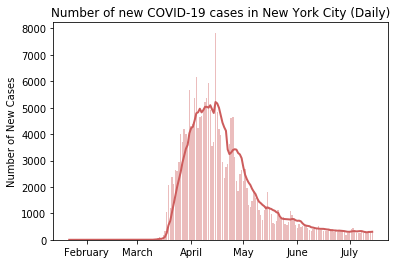

In [12]:
locator = mdates.MonthLocator()
fmt = mdates.DateFormatter('%B')

nyc_time_series = pd.DataFrame(df, columns = ['Date','Confirmed_Cases', 'New_Cases', 'Seven_Day_Avg'])
nyc_time_series['Date'] = pd.to_datetime(nyc_time_series['Date'], format='%m/%d/%y')

drawNewCases(nyc_time_series, 'Number of new COVID-19 cases in New York City (Daily)', 1, 'x')

##### Filtering for New Orleans Cases

In [13]:
cases_filtered_newo = covid_cases[covid_cases['FIPS'] == 22071]


df_newo = cases_filtered_newo.iloc[:, 11:186:1]

df_newo = df_newo.transpose().reset_index()
df_newo = df_newo.rename(columns={'index': 'Date', 1153: "Confirmed_Cases"})

newo_time_series = pd.DataFrame(df_newo, columns = ['Date','Confirmed_Cases'])
newo_time_series['Date'] = pd.to_datetime(newo_time_series['Date'], format='%m/%d/%y')

In [14]:
newo_time_series.tail()

,Date,Confirmed_Cases
170,2020-07-10,8476
171,2020-07-11,8598
172,2020-07-12,8665
173,2020-07-13,8745
174,2020-07-14,8846


In [15]:
df_newo = add_newcases(newo_time_series)
df_newo = add_sevenday(df_newo)

In [16]:
newo_time_series = pd.DataFrame(df_newo, columns = ['Date','Confirmed_Cases', 'New_Cases', 'Seven_Day_Avg'])
newo_time_series['Date'] = pd.to_datetime(newo_time_series['Date'], format='%m/%d/%y')

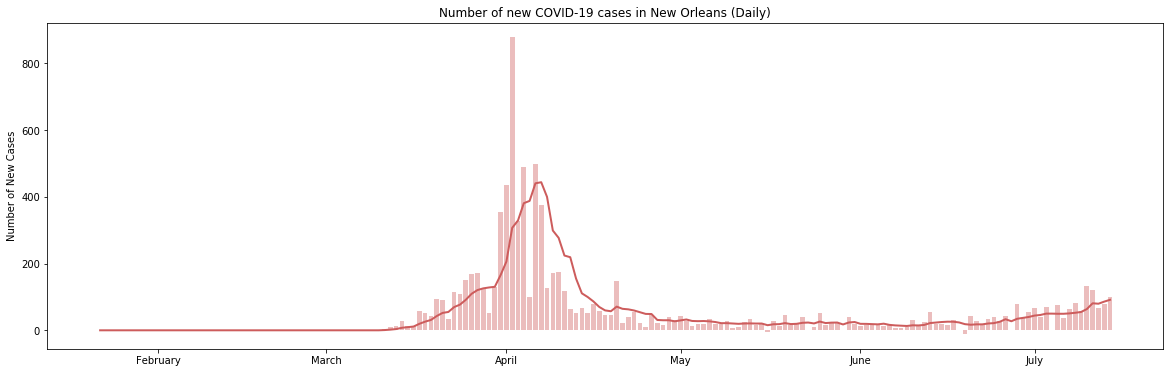

In [17]:
drawNewCases(newo_time_series, 'Number of new COVID-19 cases in New Orleans (Daily)', 2, 'y')

**Note from Zach**: Will remove this commented-out code later (see below), but thought I'd leave it just in case it'll be helpful for future visualizations:

In [18]:
# locator = mdates.MonthLocator()
# fmt = mdates.DateFormatter('%B')


# plt.plot(nyc_time_series['Date'], nyc_time_series['Confirmed_Cases'], c='indianred')
# plt.plot(legend=None)
# plt.title('Number of Confirmed COVID-19 Cases in New York City')
# plt.xlabel('Date')
# plt.ylabel('Number of Confirmed Cases')
# plt.gca().xaxis.set_major_formatter(fmt)
# plt.show()